In [2]:
import puffin.tardis_importer as ti
import numpy as np
import pandas as pd
symbol = 'BTC'
spot_trades = ti.generate_trade_data_from_gzip(f'{symbol}/USD', f'./datasets/ftx_trades_2021-10-28_{symbol}-USD.csv.gz')
spot_trades['timestamp'] = spot_trades['exchange_timestamp_nanos'] // 1000000000
spot_trades['timestamp_shifted'] = (spot_trades['exchange_timestamp_nanos'] + 50000000) // 1000000000
def vwap(df):
    return np.average(df['price'], weights=df['size'])
data = pd.DataFrame(index=range(spot_trades['timestamp'].min(), spot_trades['timestamp'].max() + 1))
original = spot_trades[['timestamp', 'price', 'size']]
original = original.groupby('timestamp').apply(vwap).to_frame('vwap_original')
shifted = spot_trades[['timestamp_shifted', 'price', 'size']]
shifted = shifted.groupby('timestamp_shifted').apply(vwap).to_frame('vwap_shifted')
data = pd.merge(left=data, right=original, how='left', left_index=True, right_index=True)
data = pd.merge(left=data, right=shifted, how='left', left_index=True, right_index=True)
data = data.fillna(method='ffill')
data = data.diff()
data = data.dropna(how='any')
data

,vwap_original,vwap_shifted
1635379202,6.069503,6.069503
1635379203,1.930497,1.930497
1635379204,0.010449,0.010449
1635379205,5.066474,5.066474
1635379206,-1.076923,-1.076923
...,...,...
1635465595,0.000000,0.000000
1635465596,0.000000,0.000000
1635465597,0.000000,0.000000
1635465598,0.000000,0.000000


In [3]:
len(data[data.vwap_original != data.vwap_shifted])/len(data)

0.12161161137989306

In [4]:
autocorr_original = data['vwap_original'].rolling(60).apply(lambda x: x.autocorr(), raw=False).to_frame()
autocorr_shifted = data['vwap_shifted'].rolling(60).apply(lambda x: x.autocorr(), raw=False).to_frame()
data = pd.merge(left=autocorr_original, right=autocorr_shifted, how='left', left_index=True, right_index=True)
data

,vwap_original,vwap_shifted
1635379202,NaN,NaN
1635379203,NaN,NaN
1635379204,NaN,NaN
1635379205,NaN,NaN
1635379206,NaN,NaN
...,...,...
1635465595,0.092300,0.092300
1635465596,0.092300,0.092300
1635465597,0.092300,0.092300
1635465598,0.092300,0.092300


In [16]:
data[np.logical_and(data.vwap_original > 0, data.vwap_shifted < -0.5)]

,vwap_original,vwap_shifted


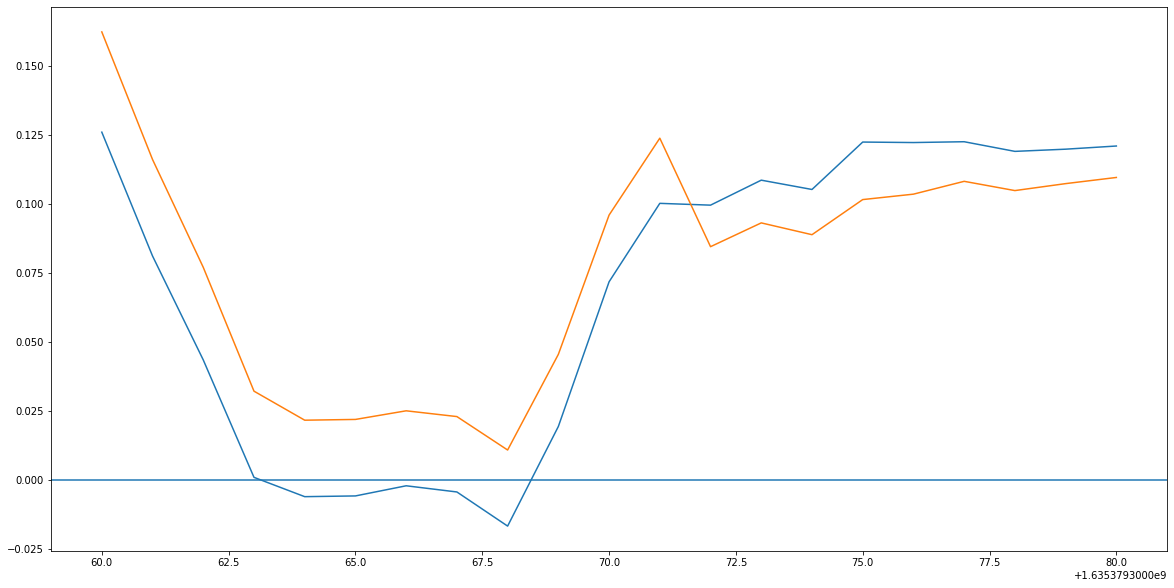

In [145]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
plt.plot(data['vwap_original'][np.logical_and(data.index >= 1635379360, data.index <= 1635379380)])
plt.plot(data['vwap_shifted'][np.logical_and(data.index >= 1635379360, data.index <= 1635379380)])
plt.axhline(0)